In [134]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [135]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
def replace(data):
    data["Sex"] = data["Sex"].replace({'female':0, 'male':1})
    data["Embarked"] = data["Embarked"].apply(lambda item: {'C':1, 'Q':2, 'S':3}.get(item))     
    data["Deck"] = data[data["Cabin"].notnull()]["Cabin"].apply(lambda item: item[0])    
    
    data['Deck'] = data['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
    data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
    data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')
    
    data["Deck"] = data[data["Deck"].notnull()]["Deck"].apply(lambda item: {"ABC": 1, "DE": 2, "FG": 3}.get(item))    
    
    return data

In [137]:
from sklearn.ensemble import RandomForestClassifier
# replacing NaN with predicted values
def Calc_NaN(data, name, features):    
    y = data[data[name].notnull()][name].apply(lambda item: int(item))    
    X = pd.get_dummies(data[data[name].notnull()][features])
    NaN = data[data[name].isnull()]
    X_NaN = pd.get_dummies(NaN[features])
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
    model.fit(X, y)
    predictions = model.predict(X_NaN)

    data = data.set_index('PassengerId')
    updt = pd.DataFrame({'PassengerId': NaN.PassengerId, name: predictions}).set_index('PassengerId')
    data.update(updt)
    data.reset_index(inplace=True)
    
    return data

In [138]:
train_data = replace(train_data)

train_data = Calc_NaN(train_data, "Embarked", ["Pclass", "Sex", "SibSp", "Parch"])
train_data = Calc_NaN(train_data, "Age", ["Pclass", "Sex", "SibSp", "Parch", "Embarked"])
train_data = Calc_NaN(train_data, "Deck", ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Age"])

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    float64
 12  Deck         891 non-null    float64
dtypes: float64(4), int64(6), object(3)
memory usage: 90.6+ KB


In [139]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

test_data = replace(test_data)

test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,2,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,3,NaN
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,2,NaN
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,3,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,3,NaN


In [140]:
test_data = Calc_NaN(test_data, "Age", ["Pclass", "Sex", "SibSp", "Parch", "Embarked"])
test_data = Calc_NaN(test_data, "Deck", ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Age"])

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    int64  
 11  Deck         418 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 39.3+ KB


In [141]:
women = train_data.loc[train_data.Sex == 0]["Survived"]
print("% of women who survived:", sum(women)/len(women))
men = train_data.loc[train_data.Sex == 1]["Survived"]
print("% of men who survived:", sum(men)/len(men))

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


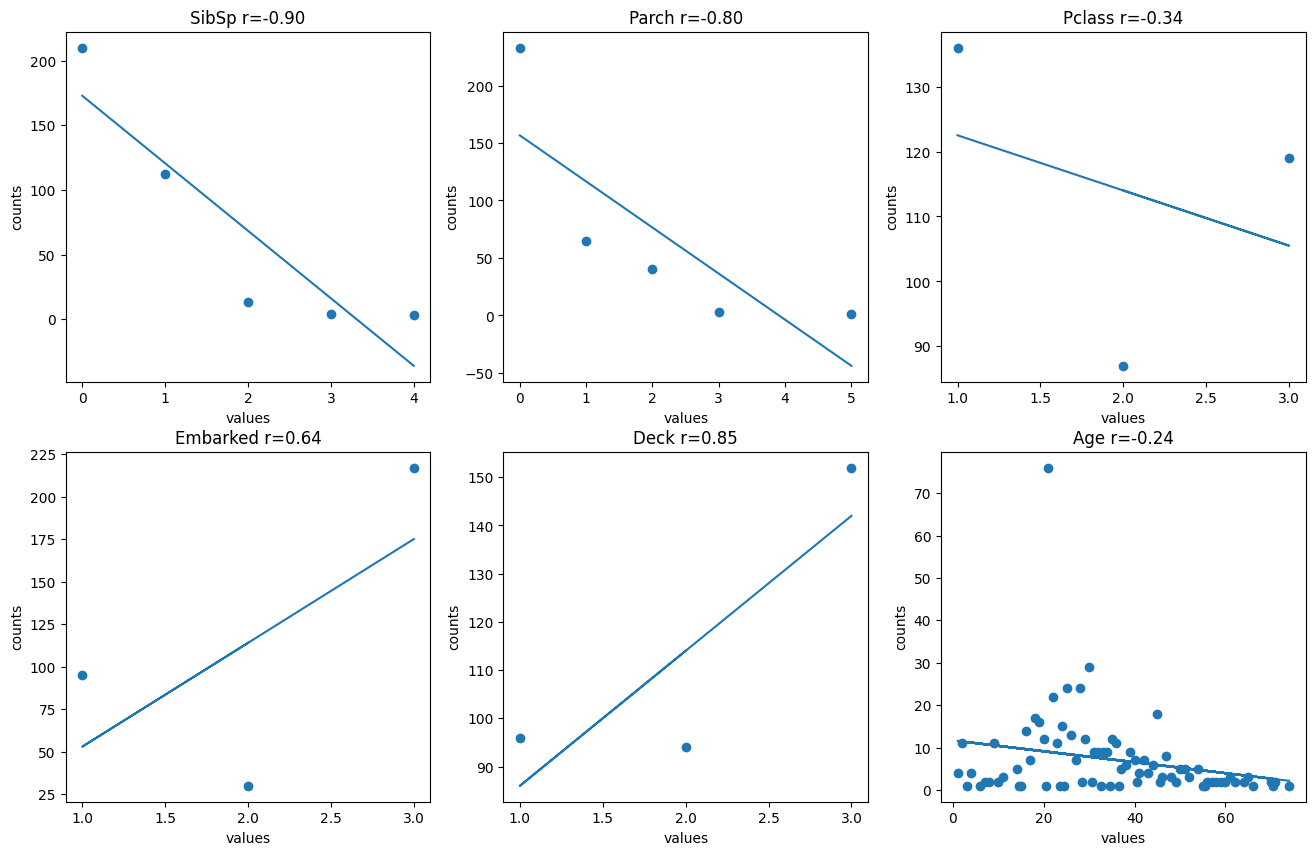

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
features = {"SibSp":1, "Parch":1, "Pclass":1, "Embarked":1, "Deck":1, "Age":0}

for key, value in features.items():
    value_count = train_data.loc[train_data.Survived == value][key].value_counts()
    x = np.array(value_count.index.tolist())
    y = np.array(value_count.tolist())
    b1 = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x ** 2) - np.mean(x) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
 
    plt.subplot(2, 3, list(features.keys()).index(key) + 1)
    plt.scatter(x, y)
    plt.plot(x, b0 + b1 * x)
    plt.title(f"{key} r={np.corrcoef(x, y)[1][0]:.2f}")
    plt.xlabel('values')
    plt.ylabel('counts')    

plt.show()

In [143]:
from sklearn.metrics import r2_score as r2

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values, cv_score):
    print(f"Train R2:\t{round(r2(train_true_values, train_pred_values), 3)}")
    print(f"Test R2:\t{round(r2(test_true_values, test_pred_values), 3)}")    
    print(f"Score:\t\t{round(cv_score.mean(), 3)}")

In [144]:
features = ["Sex", "SibSp", "Parch", "Pclass", "Embarked", "Deck", "Age"]

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

def model_testR2(data, model):        
    y = data["Survived"]        
    X = pd.get_dummies(data[features])
    
    scaler = StandardScaler()
    scaler.fit(X)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
    
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    model.fit(X_train, y_train)

    y_train_preds = model.predict(X_train)
    y_valid_preds = model.predict(X_valid)    
    
    cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
    
    return [y_train, y_train_preds, y_valid, y_valid_preds, cv_score]    

In [146]:
# coefficient of determination
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

y_train1, y_train_preds1, y_valid1, y_valid_preds1, cv_score1 = model_testR2(train_data, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1))
y_train2, y_train_preds2, y_valid2, y_valid_preds2, cv_score2 = model_testR2(train_data, CatBoostClassifier(iterations=32, depth=15, loss_function='Logloss', silent=True, ))
y_train3, y_train_preds3, y_valid3, y_valid_preds3, cv_score3 = model_testR2(train_data, CatBoostRegressor(depth=9, l2_leaf_reg=2, iterations=1000, loss_function='RMSE', eval_metric='RMSE', random_seed=21, silent=True, ))

y_train = np.array(tuple(map(lambda item: 1 if item > 0.5 else 0, np.mean(np.array([ y_train1, y_train2, y_train3 ]), axis=0))))
y_valid = np.array(tuple(map(lambda item: 1 if item > 0.5 else 0, np.mean(np.array([ y_valid1, y_valid2, y_valid3 ]), axis=0))))

y_train_preds = np.array(tuple(map(lambda item: 1 if item > 0.5 else 0, np.mean(np.array([ y_train_preds1, y_train_preds2, y_train_preds3 ]), axis=0))))
y_valid_preds = np.array(tuple(map(lambda item: 1 if item > 0.5 else 0, np.mean(np.array([ y_valid_preds1, y_valid_preds2, y_valid_preds3 ]), axis=0))))

cv_score = np.mean(np.array([ cv_score1, cv_score2, cv_score2 ]), axis=0)

print("RandomForestClassifier")
evaluate_preds(y_train1, y_train_preds1, y_valid1, y_valid_preds1, cv_score1)
print("CatBoostClassifier")
evaluate_preds(y_train2, y_train_preds2, y_valid2, y_valid_preds2, cv_score2)
print("CatBoostRegressor")
evaluate_preds(y_train3, y_train_preds3, y_valid3, y_valid_preds3, cv_score3)
print("Mean")
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds, cv_score)

RandomForestClassifier
Train R2:	0.366
Test R2:	0.171
Score:		0.186
CatBoostClassifier
Train R2:	0.402
Test R2:	0.24
Score:		0.168
CatBoostRegressor
Train R2:	0.766
Test R2:	0.41
Score:		0.314
Mean
Train R2:	0.42
Test R2:	0.217
Score:		0.174


In [147]:
def model_predict(train_data, test_data, model):    
    X = pd.get_dummies(train_data[features])
    y = train_data["Survived"]
    X_test = pd.get_dummies(test_data[features])
    
    all_data = pd.concat([train_data, test_data])
        
    scaler = StandardScaler()
    scaler.fit(all_data[features])
    
    X = scaler.transform(X)
    X_test = scaler.transform(X_test)
    
    model.fit(X, y)
        
    return model.predict(X_test)

In [148]:
result1 = model_predict(train_data, test_data, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1))
result2 = model_predict(train_data, test_data, CatBoostClassifier(iterations=32, depth=15, loss_function='Logloss', silent=True, ))
result3 = model_predict(train_data, test_data, CatBoostRegressor(depth=9, l2_leaf_reg=2, iterations=1000, loss_function='RMSE', eval_metric='RMSE', random_seed=21, silent=True,))

result = np.array(tuple(map(lambda item: 1 if item > 0.5 else 0, np.mean(np.array([ result1, result2, result3 ]), axis=0))))
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': result})    

output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
